In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [28]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    cell_ind=[]
    patch_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(knots=1);
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight');
            plt.show();
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            err_ind.append(adap.mp_resPois(MP,uh,f))
            #print(err_ind[-1])
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], theta=0.9, TOL=0)
            #print(marked_patches)
            marked_patches = {p:None for p in marked_patches}
            #start=time.time()
            #cell_ind.append(adap.mp_resPois(MP,uh,f))
            #patch_ind.append(np.array([(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]).sum() for p in range(MP.numpatches)]))
            #err_est[i] = norm(patch_ind[-1])
            #print(patch_ind[-1])
            #marked_cells = adap.doerfler_mark(cell_ind[-1], theta,TOL=0.05)
            ##idx=np.zeros(MP.Z_ofs[-1])
            #idx[marked_cells]=1
            #cell_ratio = np.array([idx[MP.Z_ofs[p]:MP.Z_ofs[p+1]].sum()/MP.Z[p] for p in range(MP.numpatches)])
            #err_mean = np.array([np.mean(abs(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]-np.mean(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]))/np.mean(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]])) for p in range(MP.numpatches)])
            # for p in range(MP.numpatches):
            #     x = cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]
            #     print(st.varian)
            #marked_patches = adap.doerfler_mark(patch_ind[-1], theta, TOL=0.05)
            # for p in marked_patches:
            #     x = cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]]
            #     print(100*np.mean(abs(x-np.mean(x))/np.mean(x)))
            #     print(cell_ind[-1][MP.Z_ofs[p]:MP.Z_ofs[p+1]])
            
            #end = time.time()
            #print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            #marked_patches = {p:(None if err_mean[p] > 1.5 else -1) for p in marked_patches}
            #marked_patches = {p: None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            MP.h_refine(h_ref=marked_patches, return_P=False)
            end = time.time()
            #print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, patch_ind

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.h_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

In [18]:
deg=4
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=8, draw=False)
np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt',np.c_[[numdofs,H1err,L2err]])

setting up constraints took 0.0038709640502929688 seconds.
Basis setup took 0.004650592803955078 seconds
0
Refinement took 0.00013256072998046875 seconds for 3 patches.
setting up constraints took 0.003831148147583008 seconds.
Basis setup took 0.004036903381347656 seconds
Refinement took 0.009334802627563477 seconds.
setting up constraints took 0.0037679672241210938 seconds.
Basis setup took 0.0040018558502197266 seconds
1
Refinement took 0.00020241737365722656 seconds for 3 patches.
setting up constraints took 0.007082700729370117 seconds.
Basis setup took 0.0068247318267822266 seconds
Refinement took 0.016264677047729492 seconds.
setting up constraints took 0.006810903549194336 seconds.
Basis setup took 0.00669550895690918 seconds
2
Refinement took 0.00013637542724609375 seconds for 3 patches.
setting up constraints took 0.005692005157470703 seconds.
Basis setup took 0.005360126495361328 seconds
Refinement took 0.012805461883544922 seconds.
setting up constraints took 0.0056459903717

setting up constraints took 0.00473332405090332 seconds.
Basis setup took 0.005810737609863281 seconds
0


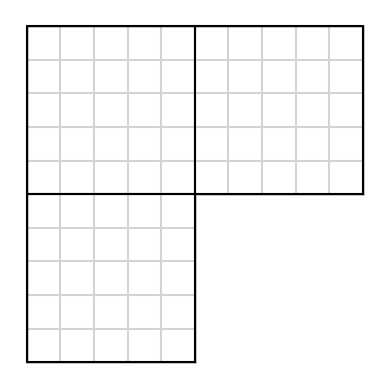

Residual contributions took 0.020902156829833984 seconds.
Jump contributions took 0.011840105056762695 seconds.
Refinement took 0.009347915649414062 seconds for 3 patches.
setting up constraints took 0.03292489051818848 seconds.
Basis setup took 0.009776830673217773 seconds
1


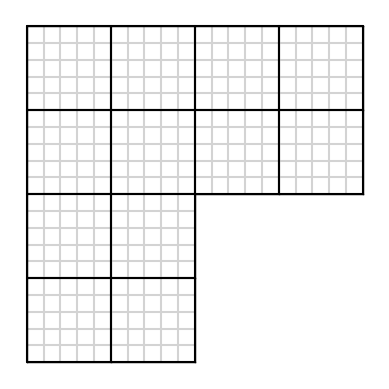

Residual contributions took 0.07903337478637695 seconds.
Jump contributions took 0.08820176124572754 seconds.
Refinement took 0.009818077087402344 seconds for 3 patches.
setting up constraints took 0.0622715950012207 seconds.
Basis setup took 0.012253046035766602 seconds
2


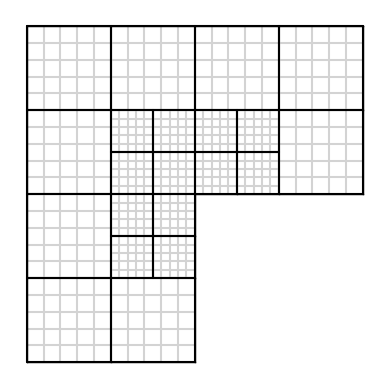

Residual contributions took 0.1286466121673584 seconds.
Jump contributions took 0.19489836692810059 seconds.
Refinement took 0.013347625732421875 seconds for 3 patches.
setting up constraints took 0.10181879997253418 seconds.
Basis setup took 0.01637554168701172 seconds
3


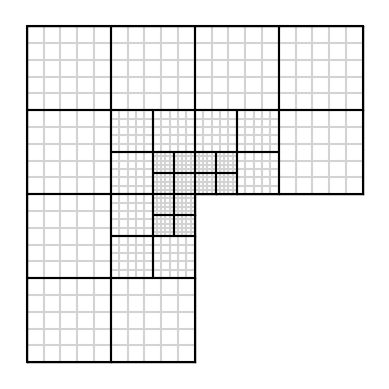

Residual contributions took 0.18569540977478027 seconds.
Jump contributions took 0.30344128608703613 seconds.
Refinement took 0.01405787467956543 seconds for 3 patches.
setting up constraints took 0.12889504432678223 seconds.
Basis setup took 0.0202329158782959 seconds
4


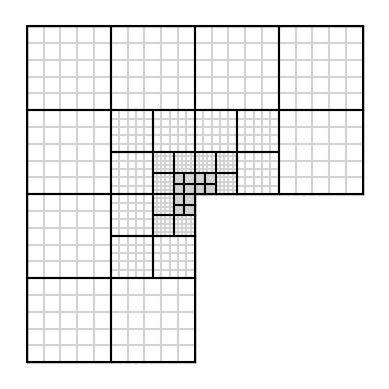

Residual contributions took 0.24204325675964355 seconds.
Jump contributions took 0.42893433570861816 seconds.
Refinement took 0.016336917877197266 seconds for 3 patches.
setting up constraints took 0.18256473541259766 seconds.
Basis setup took 0.02672266960144043 seconds
5


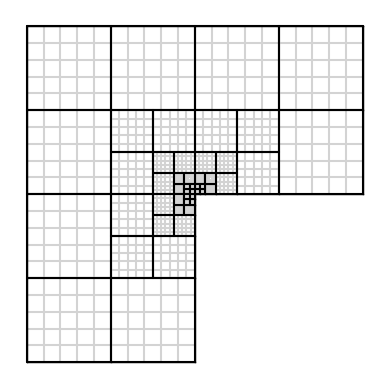

Residual contributions took 0.35182762145996094 seconds.
Jump contributions took 0.5313942432403564 seconds.
Refinement took 0.017424345016479492 seconds for 3 patches.
setting up constraints took 0.2134838104248047 seconds.
Basis setup took 0.032943010330200195 seconds
6


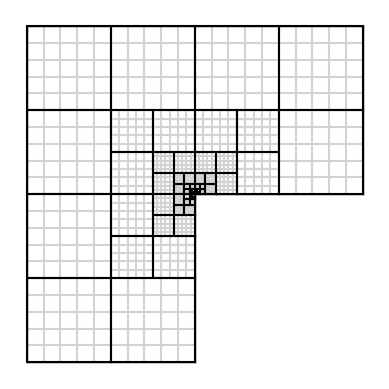

Residual contributions took 0.35453367233276367 seconds.
Jump contributions took 0.6584839820861816 seconds.
Refinement took 0.02053976058959961 seconds for 3 patches.
setting up constraints took 0.258927583694458 seconds.
Basis setup took 0.03536486625671387 seconds
7


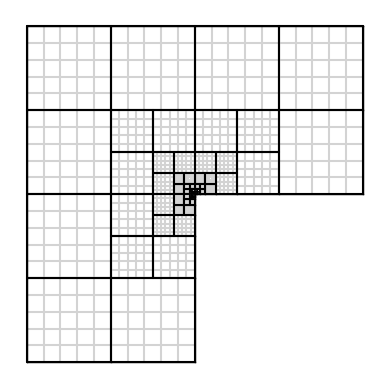

Residual contributions took 0.4092848300933838 seconds.
Jump contributions took 0.7623202800750732 seconds.
Refinement took 0.021212100982666016 seconds for 3 patches.
setting up constraints took 0.29491662979125977 seconds.
Basis setup took 0.0411992073059082 seconds
8


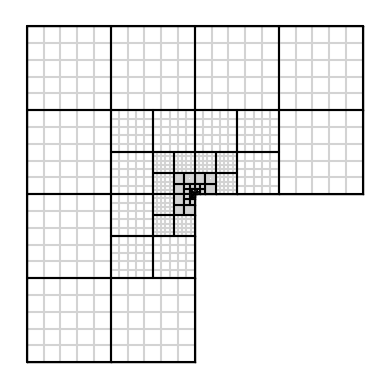

Residual contributions took 0.4718821048736572 seconds.
Jump contributions took 0.8884422779083252 seconds.
Refinement took 0.025541305541992188 seconds for 3 patches.
setting up constraints took 0.3377566337585449 seconds.
Basis setup took 0.044068336486816406 seconds
9


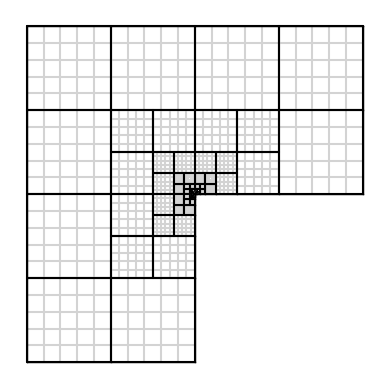

Residual contributions took 0.5258488655090332 seconds.
Jump contributions took 0.9863643646240234 seconds.
Refinement took 0.025094985961914062 seconds for 3 patches.
setting up constraints took 0.3720886707305908 seconds.
Basis setup took 0.044820308685302734 seconds
10


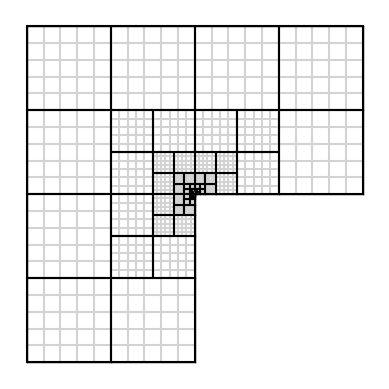

Residual contributions took 0.5833942890167236 seconds.
Jump contributions took 1.1087253093719482 seconds.
Refinement took 0.027354955673217773 seconds for 3 patches.
setting up constraints took 0.40859484672546387 seconds.
Basis setup took 0.04963088035583496 seconds
11


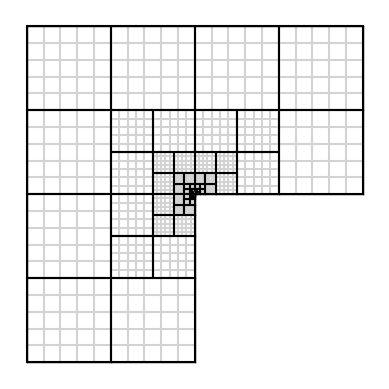

Residual contributions took 0.6400799751281738 seconds.
Jump contributions took 1.2184863090515137 seconds.
Refinement took 0.028798341751098633 seconds for 3 patches.
setting up constraints took 0.4486730098724365 seconds.
Basis setup took 0.0526881217956543 seconds
12


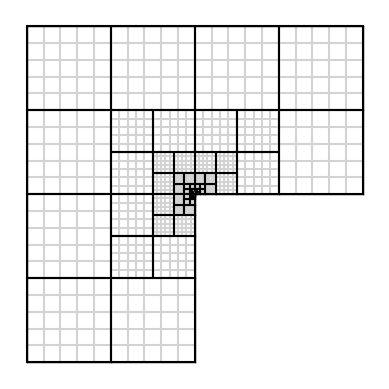

Residual contributions took 0.6877925395965576 seconds.
Jump contributions took 1.3327724933624268 seconds.
Refinement took 0.030794858932495117 seconds for 3 patches.
setting up constraints took 0.48743295669555664 seconds.
Basis setup took 0.057741641998291016 seconds
13


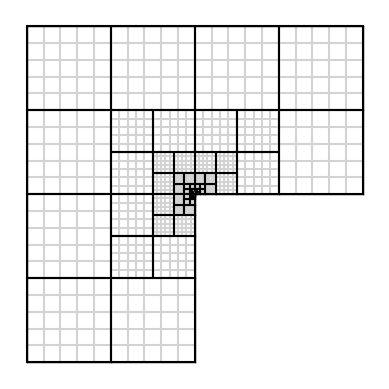

Residual contributions took 0.746579647064209 seconds.
Jump contributions took 1.4430022239685059 seconds.
Refinement took 0.03257465362548828 seconds for 3 patches.
setting up constraints took 0.5402262210845947 seconds.
Basis setup took 0.05674433708190918 seconds
14


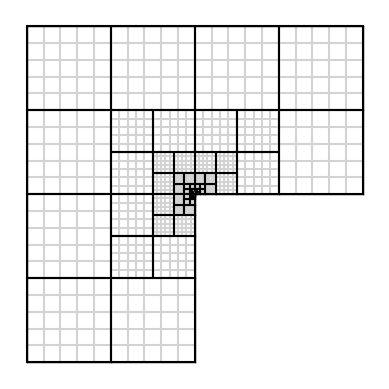

Residual contributions took 0.8342492580413818 seconds.
Jump contributions took 1.5711207389831543 seconds.
Refinement took 0.03509354591369629 seconds for 3 patches.
setting up constraints took 0.6019730567932129 seconds.
Basis setup took 0.06799149513244629 seconds
15


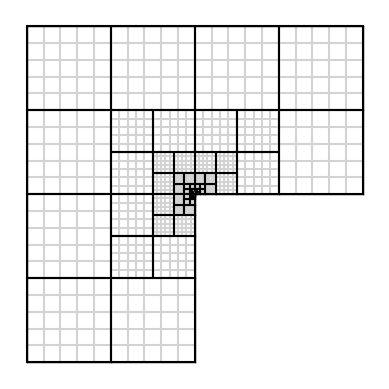

Residual contributions took 0.8742380142211914 seconds.
Jump contributions took 1.6968834400177002 seconds.
Refinement took 0.03658318519592285 seconds for 3 patches.
setting up constraints took 0.6304244995117188 seconds.
Basis setup took 0.06506705284118652 seconds
16


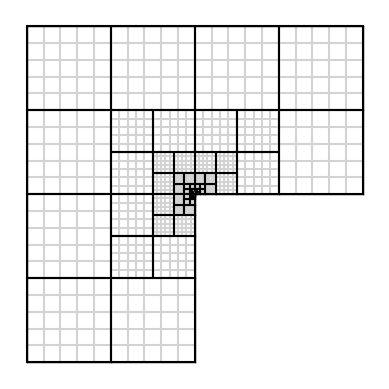

Residual contributions took 0.947514533996582 seconds.
Jump contributions took 1.778618574142456 seconds.
Refinement took 0.038140058517456055 seconds for 3 patches.
setting up constraints took 0.6544713973999023 seconds.
Basis setup took 0.06811022758483887 seconds
17


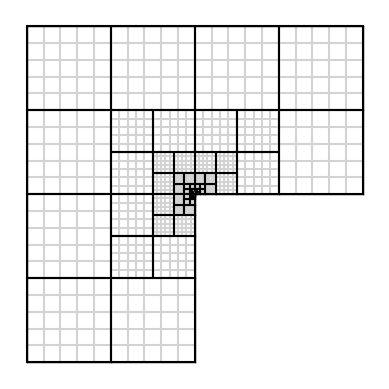

Residual contributions took 1.0045166015625 seconds.
Jump contributions took 1.8963439464569092 seconds.
Refinement took 0.03978705406188965 seconds for 3 patches.
setting up constraints took 0.7013270854949951 seconds.
Basis setup took 0.08049464225769043 seconds
18


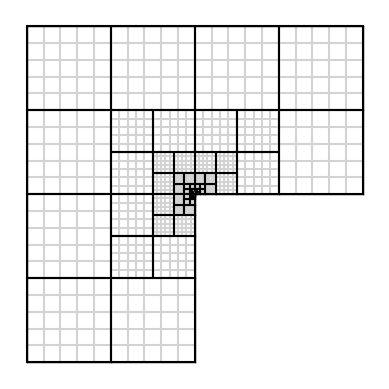

Residual contributions took 1.033081293106079 seconds.
Jump contributions took 2.0232183933258057 seconds.
Refinement took 0.04210472106933594 seconds for 3 patches.
setting up constraints took 0.7395167350769043 seconds.
Basis setup took 0.07418346405029297 seconds
19


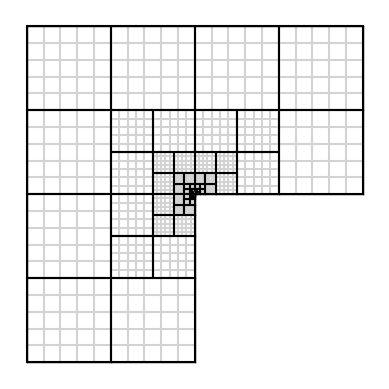

Residual contributions took 1.1032063961029053 seconds.
Jump contributions took 2.1301369667053223 seconds.
Refinement took 0.043387651443481445 seconds for 3 patches.
setting up constraints took 0.7991828918457031 seconds.
Basis setup took 0.11252117156982422 seconds
20


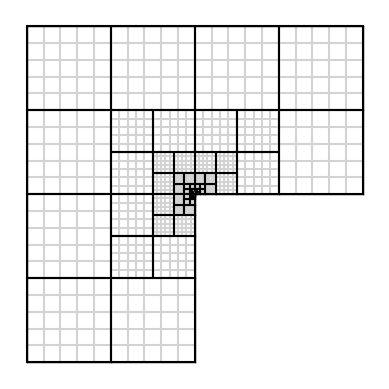

Residual contributions took 1.1572237014770508 seconds.
Jump contributions took 2.2432663440704346 seconds.
Refinement took 0.045746803283691406 seconds for 3 patches.
setting up constraints took 0.8402507305145264 seconds.
Basis setup took 0.08535361289978027 seconds
21


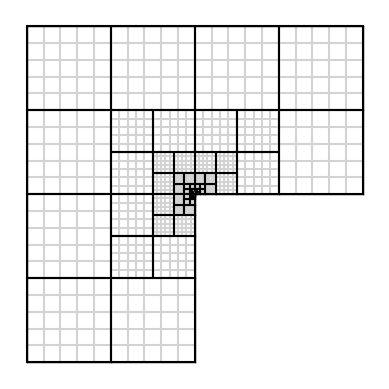

Residual contributions took 1.2247216701507568 seconds.
Jump contributions took 2.3489184379577637 seconds.
Refinement took 0.1124579906463623 seconds for 7 patches.
setting up constraints took 0.9060513973236084 seconds.
Basis setup took 0.08588361740112305 seconds
22


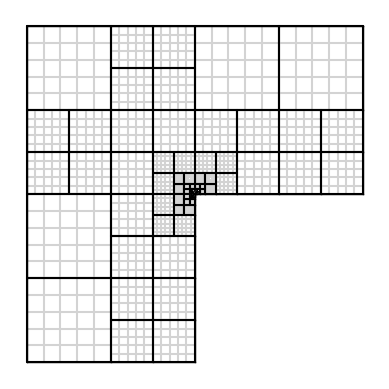

Residual contributions took 1.3879597187042236 seconds.
Jump contributions took 2.5819921493530273 seconds.
Refinement took 0.1772158145904541 seconds for 10 patches.
setting up constraints took 1.047978401184082 seconds.
Basis setup took 0.10384511947631836 seconds
23


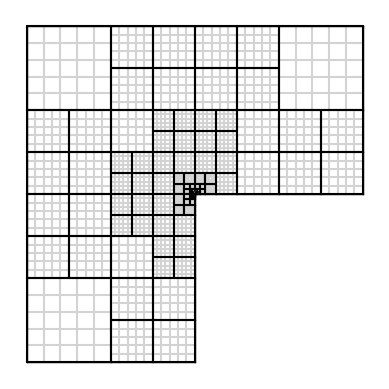

Residual contributions took 1.5604698657989502 seconds.
Jump contributions took 2.9347870349884033 seconds.
Refinement took 0.1753542423248291 seconds for 9 patches.
setting up constraints took 1.2049403190612793 seconds.
Basis setup took 0.1264791488647461 seconds
24


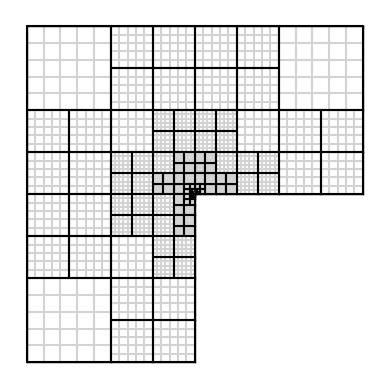

Residual contributions took 1.743454933166504 seconds.
Jump contributions took 3.3582561016082764 seconds.
Refinement took 0.24413752555847168 seconds for 11 patches.
setting up constraints took 1.3393058776855469 seconds.
Basis setup took 0.1346428394317627 seconds
25


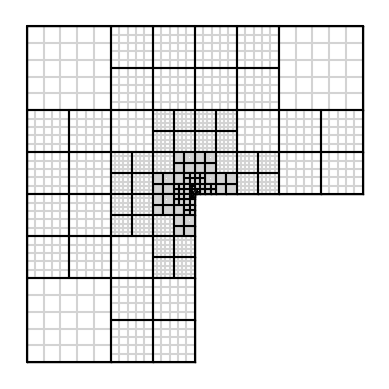

Residual contributions took 1.9825148582458496 seconds.
Jump contributions took 3.7117793560028076 seconds.
Refinement took 0.310168981552124 seconds for 13 patches.
setting up constraints took 1.53011155128479 seconds.
Basis setup took 0.16871356964111328 seconds
26


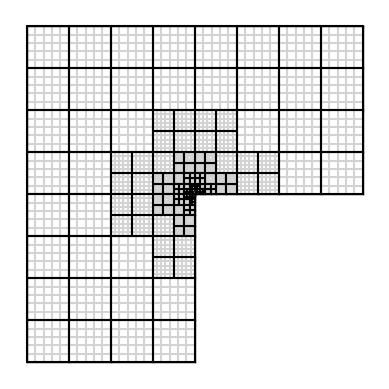

Residual contributions took 2.1742515563964844 seconds.
Jump contributions took 4.4021897315979 seconds.
Refinement took 0.3636054992675781 seconds for 13 patches.
setting up constraints took 1.7300963401794434 seconds.
Basis setup took 0.16663098335266113 seconds
27


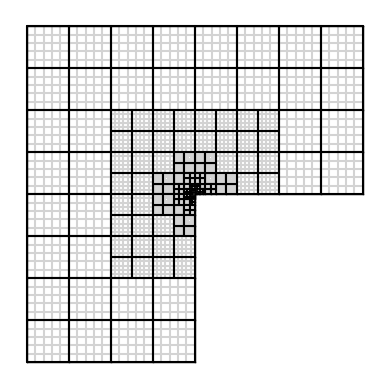

Residual contributions took 2.488720417022705 seconds.
Jump contributions took 4.579322576522827 seconds.
Refinement took 0.5827417373657227 seconds for 20 patches.
setting up constraints took 2.0027220249176025 seconds.
Basis setup took 0.21088933944702148 seconds
28


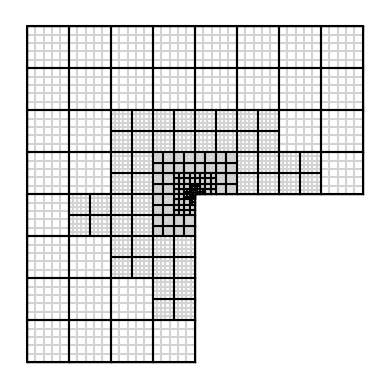

Residual contributions took 2.797016143798828 seconds.
Jump contributions took 5.285382986068726 seconds.
Refinement took 0.7414608001708984 seconds for 23 patches.
setting up constraints took 2.395545482635498 seconds.
Basis setup took 0.29137444496154785 seconds
29


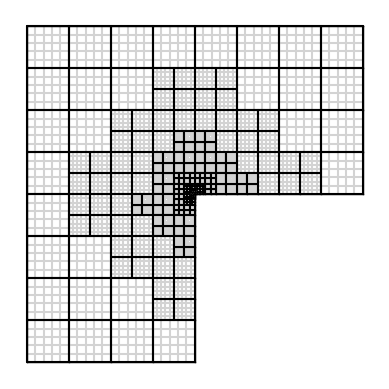

Residual contributions took 3.2694509029388428 seconds.
Jump contributions took 6.022778511047363 seconds.
Refinement took 1.0859713554382324 seconds for 29 patches.
setting up constraints took 2.8367769718170166 seconds.
Basis setup took 0.3367300033569336 seconds
30


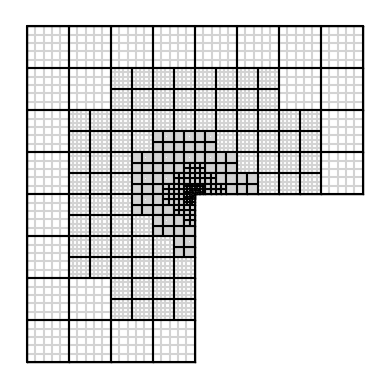

Residual contributions took 3.83752179145813 seconds.
Jump contributions took 7.1897032260894775 seconds.
Refinement took 1.5052645206451416 seconds for 36 patches.
setting up constraints took 3.4709677696228027 seconds.
Basis setup took 0.4708688259124756 seconds
31


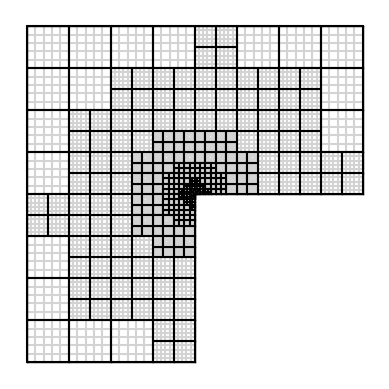

Residual contributions took 4.55170202255249 seconds.
Jump contributions took 8.335578203201294 seconds.
Refinement took 2.1469435691833496 seconds for 44 patches.
setting up constraints took 4.273538589477539 seconds.
Basis setup took 0.5939438343048096 seconds
32


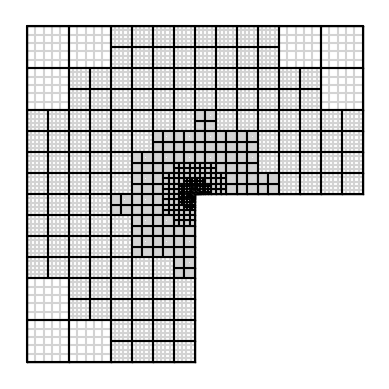

Residual contributions took 5.39068341255188 seconds.
Jump contributions took 9.789228916168213 seconds.
Refinement took 2.8204169273376465 seconds for 49 patches.
setting up constraints took 5.166334390640259 seconds.
Basis setup took 0.77333664894104 seconds
33


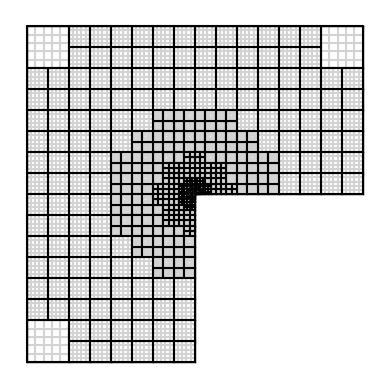

Residual contributions took 6.33109188079834 seconds.
Jump contributions took 11.505622148513794 seconds.
Refinement took 3.5768730640411377 seconds for 56 patches.
setting up constraints took 6.355427265167236 seconds.
Basis setup took 0.9161310195922852 seconds
34


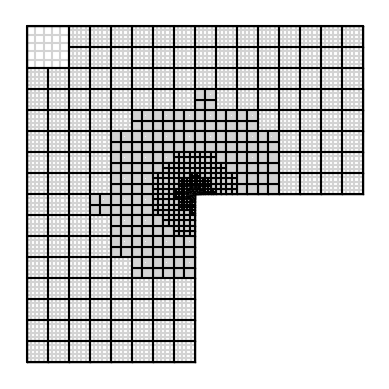

Residual contributions took 7.391433954238892 seconds.
Jump contributions took 13.408099889755249 seconds.
Refinement took 5.483066558837891 seconds for 74 patches.
setting up constraints took 8.030062198638916 seconds.
Basis setup took 1.0876643657684326 seconds
35


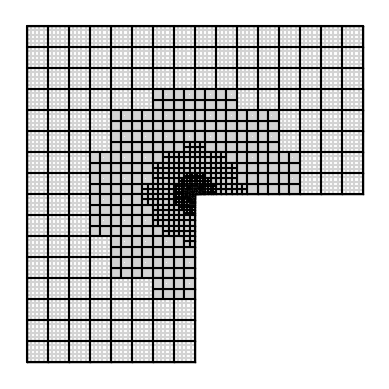

Residual contributions took 8.797427654266357 seconds.
Jump contributions took 16.024927377700806 seconds.
Refinement took 8.304880857467651 seconds for 94 patches.
setting up constraints took 10.210387706756592 seconds.
Basis setup took 1.436347246170044 seconds
36


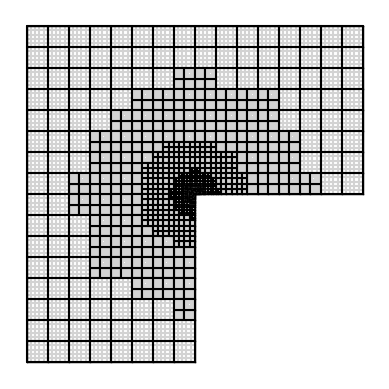

Residual contributions took 10.690829515457153 seconds.
Jump contributions took 20.345749378204346 seconds.
Refinement took 12.117803812026978 seconds for 115 patches.
setting up constraints took 13.364478588104248 seconds.
Basis setup took 2.0195882320404053 seconds
37


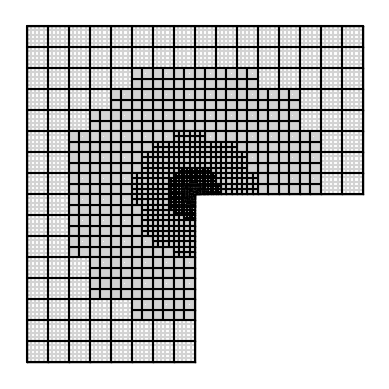

Residual contributions took 12.872829675674438 seconds.
Jump contributions took 23.235974311828613 seconds.
Refinement took 17.061457872390747 seconds for 138 patches.
setting up constraints took 17.110679864883423 seconds.
Basis setup took 2.8148717880249023 seconds
38


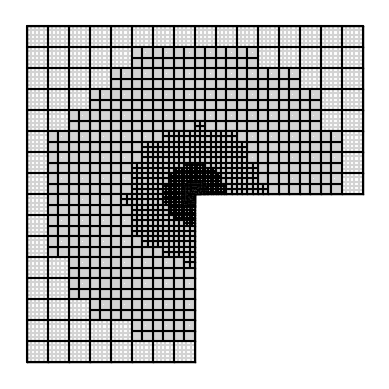

Residual contributions took 15.635129928588867 seconds.
Jump contributions took 28.04032278060913 seconds.
Refinement took 26.096659421920776 seconds for 176 patches.
setting up constraints took 23.19152808189392 seconds.
Basis setup took 3.9716930389404297 seconds
39


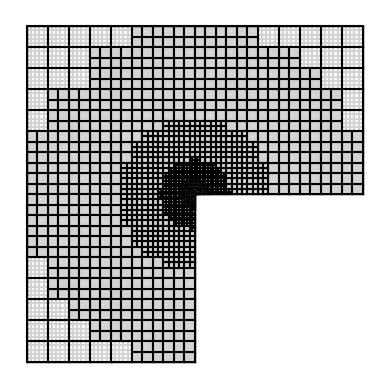

In [54]:
for deg, maxiter in zip((4,),(40,)):
    M = Lshape(deg,deg+1)
    MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=maxiter, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
    np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

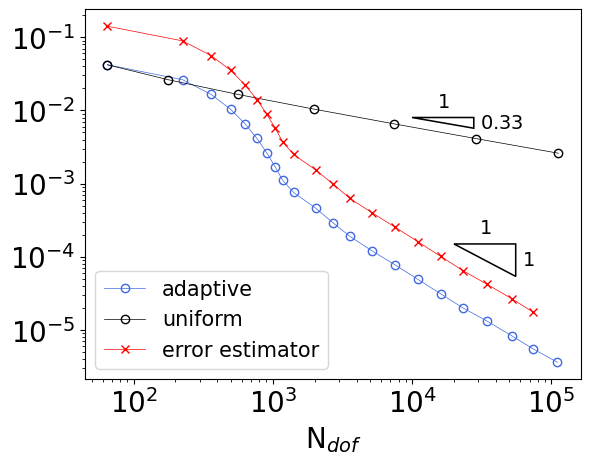

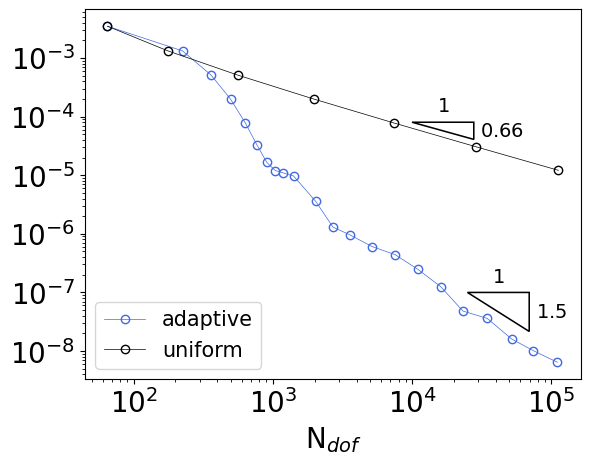

In [50]:
deg=2
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,-1))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(2*1e4,1.5*1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# ax.set_xlim([1e1,1e5]);
# ax.set_ylim([1e-8,0.3]);
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(2.5*1e4,1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-4),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

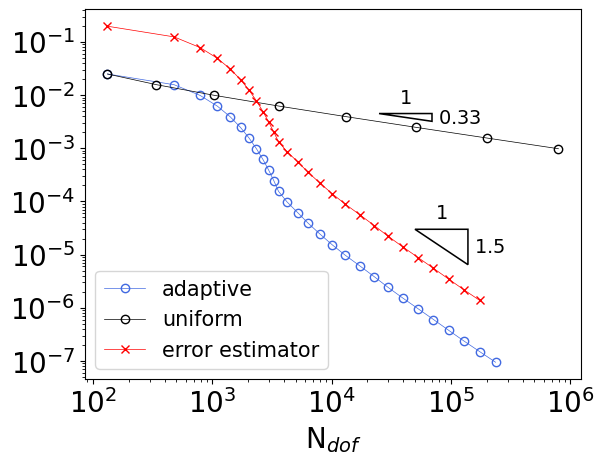

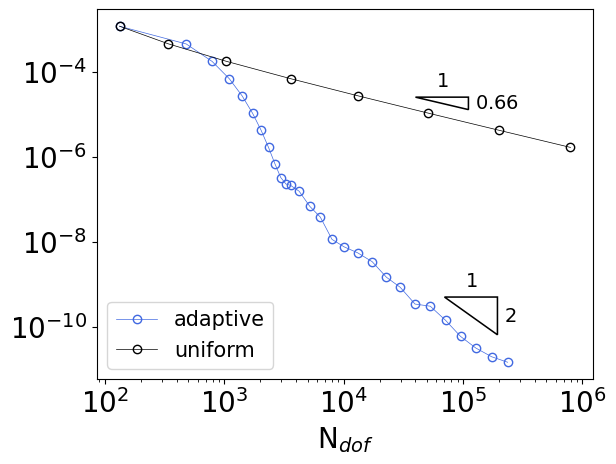

In [51]:
deg=3
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+ str(deg) +'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+ str(deg) +'/Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,-1))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(0.5*1e5,3*1e-5),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(0.25*1e5,4.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# ax.set_xlim([1,1e7]);
# ax.set_ylim([1e-8,0.3]);
# axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(0.7*1e5,0.5*1e-9),2,slope=2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(4*1e4,2.5*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

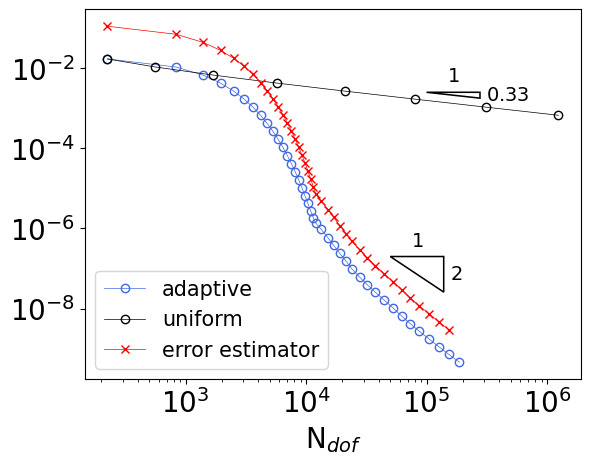

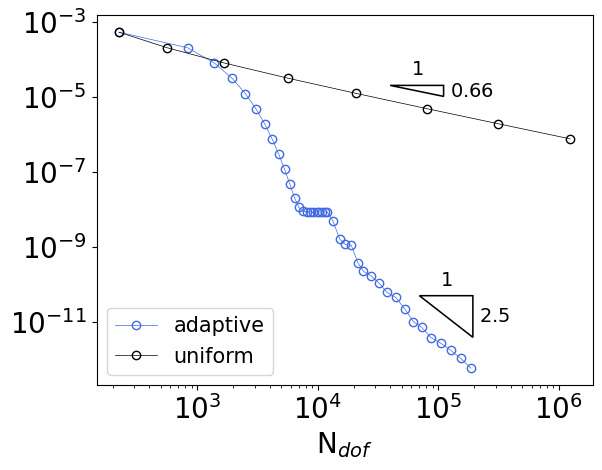

In [83]:
deg=4
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+ str(deg) +'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+ str(deg) +'/Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,-1))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(0.5*1e5,2*1e-7),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,2.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# ax.set_xlim([1,1e7]);
# ax.set_ylim([1e-8,0.3]);
# axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(0.7*1e5,5*1e-11),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(4*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()